In [6]:
from lsgp import modelGP
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.stats import chi2 

# Generate data

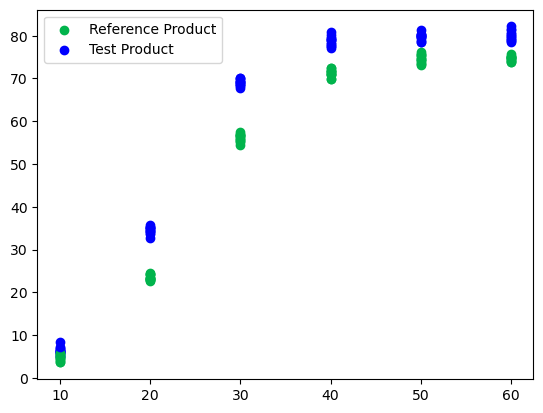

In [2]:
a2_t = 100
b_t = -0.215
a1_t = 80

a2_r = 100
b_r = -0.19
a1_r = 75

ref_data = []
test_data = []
rho = 0
sig_noise = 1
p = 6
timepoints = np.linspace(10, 60, p)
n = 12

test_data = []
ref_data = []
for i in range(n): 
    Y_T = []
    Y_R = []

    corr_struc = np.full((p,p),rho)
    np.fill_diagonal(corr_struc, 1)
    cov = corr_struc * sig_noise
    mean = np.zeros(p)
    
    noise_ref = np.random.multivariate_normal(mean, cov)
    noise_test = np.random.multivariate_normal(mean, cov)

    for t in timepoints:
        Y_R.append(a1_r / (1 + a2_r * np.exp(b_r * t)))
        Y_T.append(a1_t / (1 + a2_t * np.exp(b_t * t)))        

    Y_R = Y_R + noise_ref
    Y_T = Y_T + noise_test
    ref_data.append(Y_R)
    test_data.append(Y_T)
    
    if i == n-1:
        plt.scatter(timepoints, Y_R, color="#01b44c", label="Reference Product")
        plt.scatter(timepoints, Y_T, color="blue", label="Test Product")
    else:
        plt.scatter(timepoints, Y_R, color="#01b44c")
        plt.scatter(timepoints, Y_T, color="blue")
plt.legend()

ref_data = np.array(ref_data).T 
test_data = np.array(test_data).T
index_experiments = ["exp_0"]*p
ref_df = pd.DataFrame(ref_data)
ref_df.columns = ['Y_' + str(i) for i in range(len(ref_df.columns))]
ref_df["time"] = timepoints
ref_df["index_experiment"] = index_experiments
test_df = pd.DataFrame(test_data)
test_df.columns = ['Y_' + str(i) for i in range(len(test_df.columns))]
test_df["time"] = timepoints
test_df["index_experiment"] = index_experiments

In [3]:
class CompareDissolution:
    """
    A class which takes as input a reference set and a test set and contains methods for calculating the
    f2, the MSD-based assessment, and plotting the predictions.
    """

    def __init__(self, reference_set, test_set, expno): # tps
        self.ref = reference_set
        self.test = test_set
        self.timetest = test_set["time"]
        self.timeref = reference_set["time"]
        r = 100 # Number of timepoints to predict at
        # select exp number
        exptopredict = "exp_" + str(expno)
        self.rexp = self.ref[self.ref['index_experiment'] == exptopredict]
        self.texp = self.test[self.test['index_experiment'] == exptopredict]
        
        self.model_ref = modelGP(self.rexp, add_intercept=True, heteroskedastic=False)
        try:
            self.model_ref.fit(num_restarts=5) 
        except Exception as e:
            print(e) 

        self.model_test = modelGP(self.texp, add_intercept=True, heteroskedastic=False)
        try:
           self.model_test.fit(num_restarts=5) 
        except Exception as e:
            print(e) 
        
        # Get samples
        self.iipred = expno 
        
        # find min and max time across ref/test set & use this for predictions
        self.mintime = self.timetest[0]
        if self.timeref[0] < self.timetest[0]:
            self.mintime = self.timeref[0] 
        self.maxtime = self.timetest[len(self.timetest)-1]
        if self.timeref[len(self.timeref)-1] > self.timetest[len(self.timetest)-1]:
            self.maxtime = self.timeref[len(self.timeref)-1] 
        self.tmp = np.linspace(self.mintime, self.maxtime, r)[:, None]

        tmp = np.linspace(self.mintime, self.maxtime, r)[:, None]
        dftmp=pd.DataFrame(tmp,columns=['time'])
        dftmp['index_experiment']=exptopredict
        self.Xcolnames = [col for col in self.rexp.columns if col.startswith('X_')]
        self.dfpred_ref = pd.merge(self.rexp[self.Xcolnames+['index_experiment']].iloc[[0],:],dftmp,on=['index_experiment'])  
        Xcolnames_test = [col for col in self.texp.columns if col.startswith('X_')]
        self.dfpred_test = pd.merge(self.texp[Xcolnames_test+['index_experiment']].iloc[[0],:],dftmp,on=['index_experiment'])  

        try:
            pred_ret_test = self.model_test.predict(self.dfpred_test, nsamples=1000)
            self.pred_samples = pred_ret_test[0]
            self.test_gp_cov_mean = pred_ret_test[1]
        except Exception as e:
            print(e)
        try: 
            pred_ret_ref = self.model_ref.predict(self.dfpred_ref, nsamples=1000)
            self.pred_samples_ref = pred_ret_ref[0]
            self.ref_gp_cov_mean = pred_ret_ref[1]
        except Exception as e:
            print(e) 
        self.p = self.pred_samples["exp_" + str(self.iipred)]['f_pred_0'].shape[1] 


    def calculate_f2(self):
        f2_sample = []
        for i in range(self.pred_samples["exp_" + str(self.iipred)]['f_pred_0'].shape[0]): 
            f2 = 50 * np.log10(100 * np.power((1 + ( 1/self.p * distance.sqeuclidean(self.pred_samples_ref["exp_" + str(self.iipred)]['f_pred_0'][i], self.pred_samples["exp_" + str(self.iipred)]['f_pred_0'][i]))), -0.5)) 
            f2_sample.append(f2)
        f2_sample = np.array(f2_sample)
        avg_f2 = np.mean(f2_sample)
        return avg_f2, f2_sample


    def calculate_msd(self):
        mean_t = self.test_gp_cov_mean[0]
        s_t = self.test_gp_cov_mean[1]
        mean_ref = self.ref_gp_cov_mean[0]
        s_r = self.ref_gp_cov_mean[1]
        s_p_t = (s_r + s_t)

        mean_diff = mean_ref - mean_t

        msd_limit = []
        for ii in range(self.p):
            limit = np.zeros(self.p)
            limit[ii]=10.0
            msd_limit.append(np.power(limit.T @ np.linalg.inv(s_p_t) @ limit, 0.5))
           
        msd_limit = np.min(msd_limit)

        msd_diff = mean_diff.T @ np.linalg.inv(s_p_t) @ mean_diff
        crit_val = chi2.ppf(1 - 0.05, self.p)

        z_plus = mean_diff * (1 + np.power(crit_val/msd_diff, 0.5))
        z_minus = mean_diff * (1 - np.power(crit_val/msd_diff, 0.5))

        z_plus_dist = np.power(z_plus.T @ np.linalg.inv(s_p_t) @ z_plus, 0.5)
        z_minus_dist = np.power(z_minus.T @ np.linalg.inv(s_p_t) @ z_minus, 0.5)

        max_distance = np.max([z_plus_dist, z_minus_dist])
        if max_distance > msd_limit:
            dec = 0
            return dec, max_distance, msd_limit
        else:
            dec = 1
            return dec, max_distance, msd_limit

    def plot_predictions(self, f_t=True):
        fig = plt.figure(figsize=(12, 5)) 
        ax = fig.gca()
        plt.grid(axis = 'y')

        if f_t:
            sample_mean_ref = np.mean(self.pred_samples_ref["exp_" + str(self.iipred)]["f_pred_0"], axis=0)
            sample_lower_ref = np.percentile(self.pred_samples_ref["exp_" + str(self.iipred)]["f_pred_0"], 2.5, axis=0)
            sample_upper_ref = np.percentile(self.pred_samples_ref["exp_" + str(self.iipred)]["f_pred_0"], 97.5, axis=0)
            plt.plot(self.tmp[:,0], sample_mean_ref, color='black', alpha=0.7)
            plt.fill_between(self.tmp[:,0], sample_lower_ref, sample_upper_ref, color='red', alpha=0.5)

            sample_mean_test = np.mean(self.pred_samples["exp_" + str(self.iipred)]["f_pred_0"], axis=0)
            sample_lower_test = np.percentile(self.pred_samples["exp_" + str(self.iipred)]["f_pred_0"], 2.5, axis=0)
            sample_upper_test = np.percentile(self.pred_samples["exp_" + str(self.iipred)]["f_pred_0"], 97.5, axis=0)
            plt.plot(self.tmp[:,0], sample_mean_test, color='black', alpha=0.7)
            plt.fill_between(self.tmp[:,0], sample_lower_test, sample_upper_test, color='red', alpha=0.5)

        else:
            sample_mean_ref = np.mean(self.pred_samples_ref["exp_" + str(self.iipred)]["y_pred_0"], axis=0)
            sample_lower_ref = np.percentile(self.pred_samples_ref["exp_" + str(self.iipred)]["y_pred_0"], 2.5, axis=0)
            sample_upper_ref = np.percentile(self.pred_samples_ref["exp_" + str(self.iipred)]["y_pred_0"], 97.5, axis=0)
            plt.plot(self.tmp[:,0], sample_mean_ref, color='black', alpha=0.7)
            plt.fill_between(self.tmp[:,0], sample_lower_ref, sample_upper_ref, color='red', alpha=0.5)

            sample_mean_test = np.mean(self.pred_samples["exp_" + str(self.iipred)]["y_pred_0"], axis=0)
            sample_lower_test = np.percentile(self.pred_samples["exp_" + str(self.iipred)]["y_pred_0"], 2.5, axis=0)
            sample_upper_test = np.percentile(self.pred_samples["exp_" + str(self.iipred)]["y_pred_0"], 97.5, axis=0)
            plt.plot(self.tmp[:,0], sample_mean_test, color='black', alpha=0.7)
            plt.fill_between(self.tmp[:,0], sample_lower_test, sample_upper_test, color='red', alpha=0.5)

        Ycolnames = [col for col in self.rexp.columns if col.startswith('Y_')]
        for ycol in Ycolnames:
            if ycol == Ycolnames[len(Ycolnames)-1]:
                plt.plot(self.rexp['time'], self.rexp[ycol], ".", ms=4, color='#01b44c', label="Reference Product")
                plt.plot(self.texp['time'], self.texp[ycol], ".", ms=4, color='blue', label="Test Product")
            else:
                plt.plot(self.rexp['time'], self.rexp[ycol], ".", ms=4, color='#01b44c')
                plt.plot(self.texp['time'], self.texp[ycol], ".", ms=4, color='blue')

        # axis labels and title
        plt.xlabel("Time", fontsize=20)
        if f_t:
            plt.ylabel("f(t)", fontsize=20)
        else:
            plt.ylabel("y(t)", fontsize=20)
        plt.xlim([0, self.maxtime + 2]) 
        plt.legend(fontsize=18, loc = 'lower right')
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.tight_layout()
        plt.show()

# Run LSGP

In [4]:
res = CompareDissolution(ref_df, test_df, 0)

Output()

Output()

Output()

Output()

Output()

{'theta1': array([[4.30933208]]), 'theta2': array([[4.54167562]]), 'b': array([[-1.67053888]]), 'sigmak_interval__': array(-36.33995416), 'a_noise_0': array(-0.4909184), 'b_noise_0': array(8.09240786e-07), 'sigmak': array(0.0001), 'sigma^2_noise_0': array([0.62206401, 0.62206401, 0.62206401, 0.62206401, 0.62206401,
       0.62206401, 0.62206401, 0.62206401, 0.62206401, 0.62206401,
       0.62206401, 0.62206401, 0.62206401, 0.62206401, 0.62206401,
       0.62206401, 0.62206401, 0.62206401, 0.62206401, 0.62206401,
       0.62206401, 0.62206401, 0.62206401, 0.62206401, 0.62206401,
       0.62206401, 0.62206401, 0.62206401, 0.62206401, 0.62206401,
       0.62206401, 0.62206401, 0.62206401, 0.62206401, 0.62206401,
       0.62206401, 0.62206401, 0.62206401, 0.62206401, 0.62206401,
       0.62206401, 0.62206401, 0.62206401, 0.62206401, 0.62206401,
       0.62206401, 0.62206401, 0.62206401, 0.62206401, 0.62206401,
       0.62206401, 0.62206401, 0.62206401, 0.62206401, 0.62206401,
       0.6220

Output()

Output()

Output()

Output()

Output()

{'theta1': array([[4.37613115]]), 'theta2': array([[4.5398788]]), 'b': array([[-1.54555564]]), 'sigmak_interval__': array(-73.68391319), 'a_noise_0': array(-0.2062248), 'b_noise_0': array(4.77617707e-06), 'sigmak': array(0.0001), 'sigma^2_noise_0': array([0.82365015, 0.82365015, 0.82365015, 0.82365015, 0.82365015,
       0.82365015, 0.82365015, 0.82365015, 0.82365015, 0.82365015,
       0.82365015, 0.82365015, 0.82365015, 0.82365015, 0.82365015,
       0.82365015, 0.82365015, 0.82365015, 0.82365015, 0.82365015,
       0.82365015, 0.82365015, 0.82365015, 0.82365015, 0.82365015,
       0.82365015, 0.82365015, 0.82365015, 0.82365015, 0.82365015,
       0.82365015, 0.82365015, 0.82365015, 0.82365015, 0.82365015,
       0.82365015, 0.82365015, 0.82365015, 0.82365015, 0.82365015,
       0.82365015, 0.82365015, 0.82365015, 0.82365015, 0.82365015,
       0.82365015, 0.82365015, 0.82365015, 0.82365015, 0.82365015,
       0.82365015, 0.82365015, 0.82365015, 0.82365015, 0.82365015,
       0.82365

Sampling: [f_pred_0]


Output()

Sampling: [f_pred_0]


Output()

f2 assessment
Expected f2:  52.51976866676719
Dissolution curves similar.

MSD-based assessment
Limit distance:  74.1445589792916
MSD distance:  973.3772503468717
Dissolution curves similar.


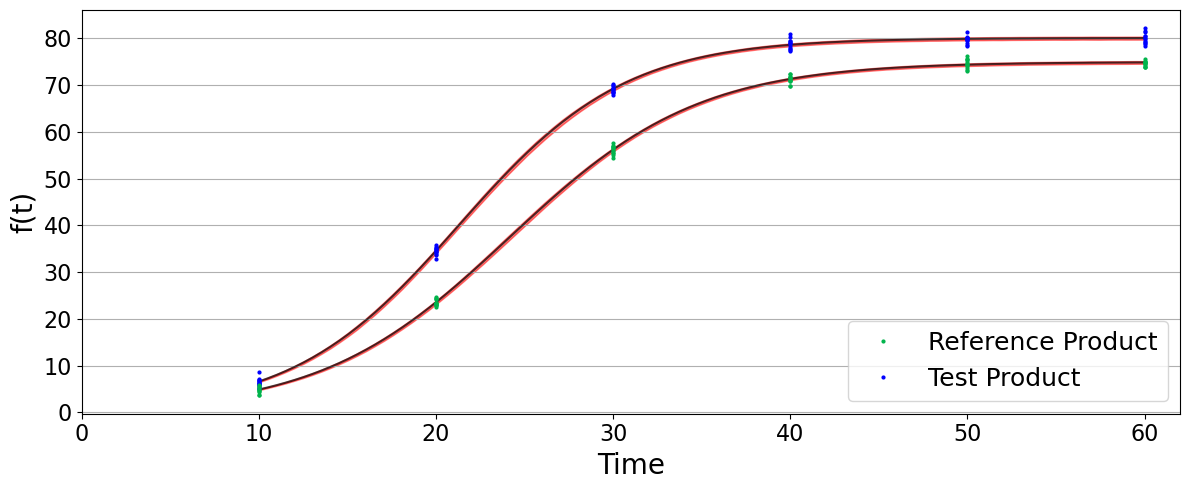

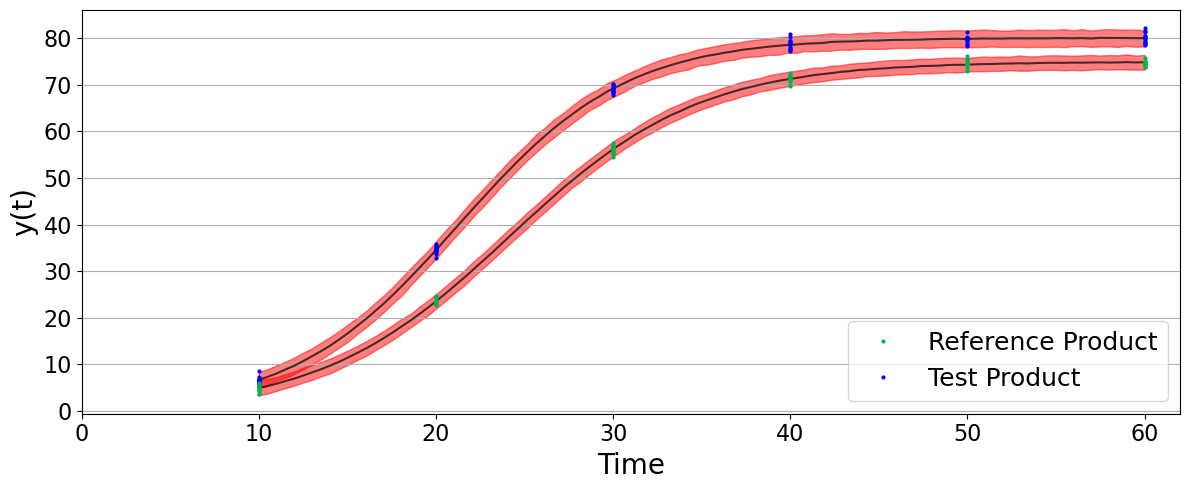

In [5]:
print("f2 assessment")
avg_fstat, fstat_samples = res.calculate_f2()
print("Expected f2: ", avg_fstat)
if avg_fstat >= 50:
    print("Dissolution curves similar.")
else:
    print("Dissolution curves dissimilar.")
print()

print("MSD-based assessment")
decision, d_limit, d_msd = res.calculate_msd()
print("Limit distance: ", d_limit)
print("MSD distance: ", d_msd)
if decision: 
    print("Dissolution curves similar.")
else:
    print("Dissolution curves dissimilar.")

res.plot_predictions()
res.plot_predictions(f_t=False) # Plot y(t) = f(t) + \epsilon(t)